In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet50
from PIL import Image
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [2]:
# ===== CONFIG =====
DATA_ROOT = "../mvtec_anomaly_detection"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

products = sorted([
    d for d in os.listdir(DATA_ROOT)
    if os.path.isdir(os.path.join(DATA_ROOT, d))
])
print("Products:", products)


Products: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


In [3]:
class MVTecDataset(Dataset):
    def __init__(self, root, product, split="train"):
        self.samples = []
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        base = os.path.join(root, product, split)

        if split == "train":
            img_dir = os.path.join(base, "good")
            for f in os.listdir(img_dir):
                self.samples.append((os.path.join(img_dir, f), 0))
        else:
            for cls in os.listdir(base):
                label = 0 if cls == "good" else 1
                img_dir = os.path.join(base, cls)
                for f in os.listdir(img_dir):
                    self.samples.append((os.path.join(img_dir, f), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        return self.transform(img), label


In [4]:
class ResNetFeature(nn.Module):
    def __init__(self, name="resnet18"):
        super().__init__()
        if name == "resnet18":
            backbone = resnet18(pretrained=True)
        else:
            backbone = resnet50(pretrained=True)

        self.features = nn.Sequential(*list(backbone.children())[:-2])

    def forward(self, x):
        f = self.features(x)
        return f.mean(dim=[2, 3])   # GAP


In [5]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [6]:
def extract_features(model, loader):
    model.eval()
    feats, labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            f = model(x)
            feats.append(f.cpu())
            labels.extend(y.numpy())

    return torch.cat(feats), np.array(labels)


In [7]:
def evaluate_feature_model(model, product):
    train_ds = MVTecDataset(DATA_ROOT, product, "train")
    test_ds  = MVTecDataset(DATA_ROOT, product, "test")

    train_loader = DataLoader(train_ds, batch_size=16, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False)

    train_feats, _ = extract_features(model, train_loader)
    test_feats, test_labels = extract_features(model, test_loader)

    scores = []
    for f in test_feats:
        d = torch.cdist(f.unsqueeze(0), train_feats)
        scores.append(d.min().item())

    return roc_auc_score(test_labels, scores)


def evaluate_autoencoder(model, product):
    model.eval()
    test_ds = MVTecDataset(DATA_ROOT, product, "test")
    loader = DataLoader(test_ds, batch_size=16, shuffle=False)

    scores, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            recon = model(x)
            err = ((x - recon) ** 2).mean(dim=[1,2,3])
            scores.extend(err.cpu().numpy())
            labels.extend(y.numpy())

    return roc_auc_score(labels, scores)


In [8]:
models = {
    "ResNet18": ResNetFeature("resnet18").to(DEVICE),
    "ResNet50": ResNetFeature("resnet50").to(DEVICE),
    "AutoEncoder": ConvAutoEncoder().to(DEVICE)
}

results = {m: [] for m in models}


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1

In [9]:
for name, model in models.items():
    print(f"\n===== {name} =====")
    for p in products:
        if name == "AutoEncoder":
            auc = evaluate_autoencoder(model, p)
        else:
            auc = evaluate_feature_model(model, p)

        results[name].append(auc)
        print(f"{p:12s}: {auc:.4f}")



===== ResNet18 =====
bottle      : 0.9937
cable       : 0.8774
capsule     : 0.8632
carpet      : 0.7705
grid        : 0.4754
hazelnut    : 0.9696
leather     : 0.8855
metal_nut   : 0.8265
pill        : 0.7526
screw       : 0.7739
tile        : 0.9737
toothbrush  : 0.9389
transistor  : 0.9125
wood        : 0.8904
zipper      : 0.9417

===== ResNet50 =====
bottle      : 0.9659
cable       : 0.8433
capsule     : 0.8568
carpet      : 0.7869
grid        : 0.3952
hazelnut    : 0.9293
leather     : 0.9939
metal_nut   : 0.7551
pill        : 0.7360
screw       : 0.7448
tile        : 0.9751
toothbrush  : 0.8694
transistor  : 0.9058
wood        : 0.9377
zipper      : 0.9407

===== AutoEncoder =====
bottle      : 0.3635
cable       : 0.5658
capsule     : 0.5600
carpet      : 0.8740
grid        : 0.0769
hazelnut    : 0.8829
leather     : 0.6641
metal_nut   : 0.5714
pill        : 0.3497
screw       : 1.0000
tile        : 0.6746
toothbrush  : 0.4500
transistor  : 0.2871
wood        : 0.4939
zipper 

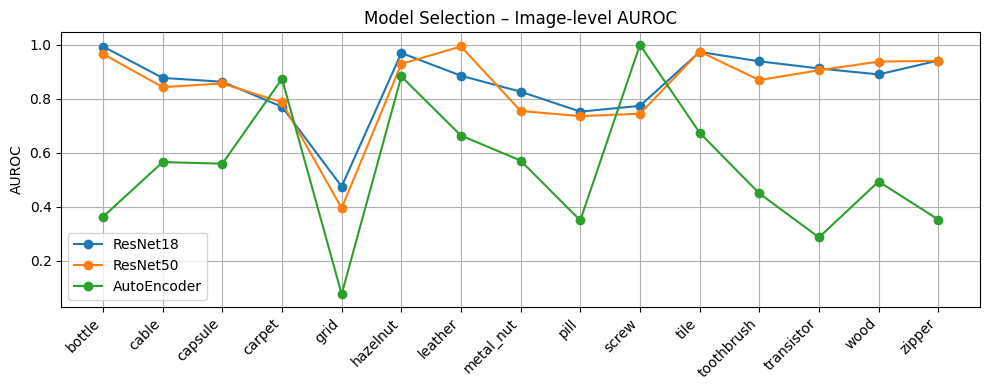

ResNet18 Mean AUROC: 0.8564
ResNet50 Mean AUROC: 0.8424
AutoEncoder Mean AUROC: 0.5445


In [10]:
plt.figure(figsize=(10, 4))

for name, aucs in results.items():
    plt.plot(products, aucs, marker="o", label=name)

plt.xticks(rotation=45, ha="right")
plt.ylabel("AUROC")
plt.title("Model Selection – Image-level AUROC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

for name, aucs in results.items():
    print(f"{name} Mean AUROC: {np.mean(aucs):.4f}")
